In [17]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('train_features_vmd_fft')
    train_ylabel = load('train_ylabel')
    # 验证集
    val_xdata = load('val_features_vmd_fft')
    val_ylabel = load('val_ylabel')
    # 测试集
    
    test_xdata = load('test_features_vmd_fft')
    test_ylabel = load('test_ylabel')
    print(len(train_xdata))
    print(len(val_xdata))
    print(len(test_xdata))
    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)

    return train_loader, val_loader, test_loader


batch_size = 64
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

7161
2046
1023
111
31
15


# 定义 通道注意力机制

In [18]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(channel, channel // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channel // reduction, channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 全局平均池化  x: torch.Size([256, 128, 121])
        out = self.avg_pool(x)
        out = out.view(out.size(0), -1)
        # Squeeze阶段：通过全连接层降维
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        # Excitation阶段：通过Sigmoid函数生成权重
        out = self.sigmoid(out)  # out: torch.Size([256, 128])
        out = out.view(out.size(0), out.size(1), -1)
        # 乘以权重，实现通道的重新加权
        out = x * out
        return out

In [19]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class LatentSpaceMonitor:
    def __init__(self):
        self.h_s_data = {'mean': [], 'std': [], 'max': [], 'min': []}
        self.h_c_data = {'mean': [], 'std': [], 'max': [], 'min': []}
        self.hooks = []
        # 原有监控数据
        self.h_s_data = {'mean': [], 'std': [], 'max': [], 'min': []}
        self.h_c_data = {'mean': [], 'std': [], 'max': [], 'min': []}
        self.hooks = []
        
        self.nan_counts = {'swin':0, 'cnn':0, 'fusion':0}  # 新增NaN计数器
        # 新增R值监控数据
        self.r_values = {
            'swin': [],   # Swin分支特征相关性
            'cnn': [],    # CNN分支特征相关性 
            'fusion': []  # 融合特征相关性
        }    
    def _h_s_hook(self, module, inputs, outputs):
        with torch.no_grad():
            self.h_s_data['mean'].append(outputs.mean().item())
            self.h_s_data['std'].append(outputs.std().item())
            self.h_s_data['max'].append(outputs.max().item())
            self.h_s_data['min'].append(outputs.min().item())
            
    def _h_c_hook(self, module, inputs, outputs):
        with torch.no_grad():
            self.h_c_data['mean'].append(outputs.mean().item())
            self.h_c_data['std'].append(outputs.std().item())
            self.h_c_data['max'].append(outputs.max().item())
            self.h_c_data['min'].append(outputs.min().item())
    
    def register_hooks(self, model):
        fusion_module = model.fusion_module
        hook1 = fusion_module.swin_proj.register_forward_hook(self._h_s_hook)
        hook2 = fusion_module.cnn_proj.register_forward_hook(self._h_c_hook)
        self.hooks.extend([hook1, hook2])
    
    def release_hooks(self):
        for hook in self.hooks:
            hook.remove()
    
    # 其他可视化方法保持不变...
    
    def visualize_statistics(self, save_path=None):
        """绘制特征统计趋势图"""
        plt.figure(figsize=(12, 6))
        
        # Swin分支统计
        plt.subplot(1, 2, 1)
        plt.plot(self.h_s_data['mean'], label='Mean', color='blue')
        plt.plot(self.h_s_data['std'], label='Std', color='red')
        plt.fill_between(range(len(self.h_s_data['mean'])), 
                        self.h_s_data['min'], 
                        self.h_s_data['max'],
                        color='gray', alpha=0.3, label='Range')
        #plt.title('Swin Path Latent Space (H={})'.format(len(self.h_s_data['mean'][0])))
        plt.title('Swin Path Latent Space')
        plt.xlabel('Batch Steps')
        plt.legend()
        
        # CNN分支统计
        plt.subplot(1, 2, 2)
        plt.plot(self.h_c_data['mean'], label='Mean', color='green')
        plt.plot(self.h_c_data['std'], label='Std', color='orange')
        plt.fill_between(range(len(self.h_c_data['mean'])), 
                        self.h_c_data['min'], 
                        self.h_c_data['max'],
                        color='gray', alpha=0.3, label='Range')
        #plt.title('CNN Path Latent Space (H={})'.format(len(self.h_c_data['mean'][0])))
        plt.title('1DCNN-SENet Path Latent Space')
        plt.xlabel('Batch Steps')
        plt.legend()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    #def visualize_distribution(self, num_samples=500, save_path=None):
    def visualize_distribution(self, model, num_samples=500, save_path=None):  # 参数顺序: self, model, num_samples, save_path
        """绘制隐空间分布可视化"""
        # 从fusion_module中获取样本
        h_s_last = model.fusion_module.h_samples[-num_samples:]
        h_c_last = model.fusion_module.c_samples[-num_samples:]
        
        # 使用PCA降维到2D
        pca = PCA(n_components=2)
        h_s_2d = pca.fit_transform(np.vstack(h_s_last))
        h_c_2d = pca.transform(np.vstack(h_c_last))
        
        plt.figure(figsize=(8, 6))
        plt.scatter(h_s_2d[:, 0], h_s_2d[:, 1], alpha=0.5, label='Swin')
        plt.scatter(h_c_2d[:, 0], h_c_2d[:, 1], alpha=0.5, label='1DCNN-SENet')
        plt.title('H Space Distribution (PCA)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend()
        
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()

    def compute_correlation(self, features):
        """增强稳定性的相关系数计算"""
        if isinstance(features, torch.Tensor):
            features = features.cpu().numpy()
        
        # 特征清洗和数值稳定处理
        features = np.nan_to_num(features, nan=0.0)
        features = features[~np.all(features == 0, axis=1)]  # 过滤全零样本
        
        # 处理常数特征
        std_dev = np.std(features, axis=0)
        non_constant = std_dev > 1e-6
        if np.sum(non_constant) < 2:  # 至少需要两个有效特征
            return np.nan
        
        valid_features = features[:, non_constant]
        
        try:
            # 手动计算协方差矩阵避免数值问题
            cov_matrix = np.cov(valid_features, rowvar=False, bias=True)
            std_dev = np.sqrt(np.diag(cov_matrix))
            std_dev[std_dev == 0] = 1e-6  # 防止除零
            
            corr_matrix = cov_matrix / np.outer(std_dev, std_dev)
            return np.abs(corr_matrix).mean()
        except:
            return np.nan

    def update_r_values(self, swin_feat, cnn_feat, fusion_feat):
        """带异常处理的更新方法"""
        def safe_update(feat, key):
            r = self.compute_correlation(feat)
            if np.isnan(r):
                self.nan_counts[key] += 1
                return 0.0  # 用0替代NaN保持可视化连续性
            return r
            
        self.r_values['swin'].append(safe_update(swin_feat, 'swin'))
        self.r_values['cnn'].append(safe_update(cnn_feat, 'cnn'))
        self.r_values['fusion'].append(safe_update(fusion_feat, 'fusion'))

    def visualize_r_trend(self, save_path=None):
        """改进的可视化方法"""
        plt.figure(figsize=(12, 6))
        
        # 过滤无效数据点
        valid_idx = ~np.isnan(self.r_values['cnn'])
        x = np.arange(len(self.r_values['cnn']))[valid_idx]
        
        plt.plot(x, np.array(self.r_values['swin'])[valid_idx], 
                label=f'Swin', alpha=0.7)
        plt.plot(x, np.array(self.r_values['cnn'])[valid_idx], 
                label=f'1DCNN-SENet', alpha=0.7)
        plt.plot(x, np.array(self.r_values['fusion'])[valid_idx],
                label='Fusion', linewidth=2)
        
        plt.title('Latent Space Correlation')
        plt.xlabel('Valid Steps')
        plt.ylabel('Mean Absolute R')
        plt.legend()
        plt.grid(alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()



# 2DSWinTransfromer-1DCNN并行分类模型

In [20]:
import torch.nn as nn
import torch
from timm.models.swin_transformer import SwinTransformer

class DualPathAttentionFusion(nn.Module):
    def __init__(self, swin_dim, cnn_dim, H=64):
        super().__init__()
        # 投影到隐空间H（添加LayerNorm）
                # ...原有代码不变...
        
        # 新增特征存储

        self.swin_features = []
        self.cnn_features = []
        self.fusion_features = []
        
        hidden_dim=64
        self.swin_proj = nn.Sequential(
            nn.Linear(swin_dim, H),
            nn.LayerNorm(H)
        )
        self.cnn_proj = nn.Sequential(
            nn.Linear(cnn_dim, H),
            nn.LayerNorm(H)
        )

        ###########


        
        # 交叉注意力使用投影后的特征
        self.swin_att = nn.Sequential(
            nn.Linear(H, H//2),  # 理论中的k=H//2
            nn.ReLU(),
            nn.Linear(H//2, H),
            nn.Sigmoid()
        )
        self.cnn_att = nn.Sequential(
            nn.Linear(H, H//2),
            nn.ReLU(),
            nn.Linear(H//2, H),
            nn.Sigmoid()
        )
        
        # 动态融合系数
        self.gamma = nn.Sequential(
            nn.Linear(2*H, H),
            nn.ReLU(),
            nn.Linear(H, 1),
            nn.Sigmoid()
        )
        # 特征压缩
        self.swin_proj = nn.Linear(swin_dim, hidden_dim)
        self.cnn_proj = nn.Linear(cnn_dim, hidden_dim)
        
        self.sampling = False
        self.h_samples = []
        self.c_samples = []
    
    def collect_samples(self, enable=True):
        """开启/关闭特征采集"""
        self.sampling = enable
        
    def forward(self, swin_feat, cnn_feat):
        
        h_s = self.swin_proj(swin_feat)
        h_c = self.cnn_proj(cnn_feat)
        
        # 检查CNN特征是否全零或常数
        if torch.all(cnn_feat == 0):
            print("Warning: CNN features are all zeros!")
        elif (cnn_feat.std(dim=1) == 0).any():
            print("Warning: Some CNN features have zero variance!")
        # 后续代码不变
        #print(cnn_feat)
        
        # 采集隐空间样本
        if self.sampling:
            self.h_samples.append(h_s.detach().cpu().numpy())
            self.c_samples.append(h_c.detach().cpu().numpy())
        
       

        



        
         # 投影到隐空间H
        h_s = self.swin_proj(swin_feat)  # [B, H]
        h_c = self.cnn_proj(cnn_feat)    # [B, H]
        
         # 添加特征稳定性处理
        cnn_feat = torch.where(torch.isnan(cnn_feat), torch.zeros_like(cnn_feat), cnn_feat)
        cnn_feat = torch.clamp(cnn_feat, -1e6, 1e6)  # 防止梯度爆炸
        
        # 添加特征标准化
        Scnn_feat = F.layer_norm(cnn_feat, cnn_feat.shape[1:])

        
        # 交叉注意力计算（使用投影后的特征）
        alpha_s = self.swin_att(h_c)     # 用CNN分支指导Swin权重
        alpha_c = self.cnn_att(h_s)      # 用Swin分支指导CNN权重
    
        # 动态融合系数
        gamma = self.gamma(torch.cat([h_s, h_c], dim=1))  # 公式(19)
    
        # 加权融合
        fusion = gamma*(h_s*alpha_s) + (1-gamma)*(h_c*alpha_c)
        if self.training:
            self.swin_features.append(swin_feat.detach().cpu())
            self.cnn_features.append(cnn_feat.detach().cpu())
            self.fusion_features.append(fusion.detach().cpu())
            
        return fusion
        
class SwinCNNSEModel(nn.Module):
    def __init__(self,  conv_archs, input_dim, output_dim, *args, **kwargs):
        super().__init__()
        
        # SwinTransformer特征提取
        self.swmodel = SwinTransformer(*args, **kwargs)

        # cnn 1D 卷积池化网络结构 + 通道注意力机制 参数
        self.conv_archs =  conv_archs  # cnn 1D 卷积池化网络结构
        self.input_channels = input_dim  # 分支 CNN输入通道数  默认三通道 输入数据
        self.cnn1d_globalfeatures = self.make_1dcnn_layers()  # 1D 卷积池化 + 通道注意力机制

        # 自适应平均池化
        self.adaptive_pool_2D = nn.AdaptiveAvgPool2d((1, 1))

        self.adaptive_pool_1D = nn.AdaptiveAvgPool1d(1)

        # 定义全连接层
        self.classifier = nn.Linear(conv_archs[-1][-1] + 64 , output_dim)

        #后加入
        self.fusion_module = DualPathAttentionFusion(
            swin_dim=64,  # 根据实际特征维度调整
            cnn_dim=128   # 根据实际特征维度调整
        )
        self.classifier = nn.Linear(64, output_dim)  # hidden_dim=64

        #
        
    # CNN 全局注意力机制 卷积池化结构
    

    """
    def make_1dcnn_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_archs:
            for _ in range(num_convs):
            
                layers.append(nn.Conv1d(self.input_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                layers.append(SEBlock(out_channels))  # 添加通道注意力机制
                self.input_channels = out_channels
                
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))  # 添加池化层
        return nn.Sequential(*layers)
    """

    def make_1dcnn_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_archs:
            for _ in range(num_convs):
                layers += [
                    nn.Conv1d(self.input_channels, out_channels, kernel_size=3, padding=1),
                    
                    nn.BatchNorm1d(out_channels, eps=1e-05, momentum=0.9, affine=True, 
track_running_stats=True, device=None, dtype=None),  # 新增BatchNorm
                   
                    nn.ReLU(inplace=True),
                    SEBlock(out_channels)
                ]
                self.input_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)

    def forward(self, input):

        # input :  torch.Size([64, 5, 1024])
        batch_size = input.size(0)
        input_dim = input.size(1)


        
        # 分支一：2D - SwinTransformer
        #改变输入形状，适应网络输入[batch, channels, width, height]
        # 注意：这里是 把数据进行了堆叠 把一个1*1024 的序列 进行 划分堆叠成形状为 32 * 32， 就使输入序列的长度降下来了  适应 SwinTransformer 输入
        swin_input = input.view(batch_size, input_dim, 32, 32)
        # 空间特征局部 SWinTransformer
        swin_features = self.swmodel.forward_features(swin_input)
        # print(swin_features.size())  #   torch.Size([64, 8, 8, 64])
        swin_features = swin_features.permute(0, 3, 1, 2)  # torch.Size([64, 64, 8, 8])
        # 自适应平均池化
        swin_adaptive_pool = self.adaptive_pool_2D(swin_features)
        # print(swin_adaptive_pool.size())  torch.Size([64, 64, 1, 1])
        # 维度压缩
        swin_out = swin_adaptive_pool.view((batch_size, -1)) # torch.Size([64, 64]

        # 分支二：1D - CNN
        # 空间全局特征 卷积池化处理
        #  输入 （batch_size, channels, length）
        cnn1d_globalfeatures = self.cnn1d_globalfeatures(input)
        # print(cnn1d_globalfeatures.size())  # torch.Size([64, 128, 128])
         # 自适应平均池化
        cnn1d_adaptive_pool = self.adaptive_pool_1D(cnn1d_globalfeatures)
        # print(cnn1d_adaptive_pool.size()) # torch.Size([64, 128, 1])
        # 维度压缩
        cnn1d__out = cnn1d_adaptive_pool.view((batch_size, -1)) # torch.Size([64, 128]

        # 模型堆叠融合
        #combined_features = torch.cat((swin_out, cnn1d__out), dim=1)  # torch.Size([64, 128 + 64]
        #outputs = self.classifier(combined_features)  # torch.Size([64, 5]

        # 改进后的融合方式
        combined_features = self.fusion_module(swin_out, cnn1d__out)
        outputs = self.classifier(combined_features)
        
        return outputs
    def get_features(self, data):
        """获取各阶段特征"""
        _ = self.forward(data)  # 触发前向计算
        return (
            torch.cat(self.fusion_module.swin_features, dim=0),
            torch.cat(self.fusion_module.cnn_features, dim=0),
            torch.cat(self.fusion_module.fusion_features, dim=0)
        )

In [21]:
# 定义模型参数
num_classes = 5 # 5分类
# 1D-CNN 参数
# VGG11，VGG13，VGG16，VGG19 可自行更换。
#conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))  # vgg11
#conv_arch = ((2, 64), (2, 128), (2 , 256), (2, 512), (2, 512))  # vgg13
#conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))  # vgg16
#conv_arch = ((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))  # vgg19
# 先用浅层试一试
conv_archs = ((1, 32), (1, 64), (1, 128))  
input_dim = 5  # 输入 5 个通道
output_dim = 5 # 5分类

# Swin Transformer 参数
img_size = 32  # 输入图像尺寸为 32x32
patch_size = 4  # 补丁尺寸为 4x4
embed_dim = 100
# depths = (2, 2, 6, 2)  原始论文参数
# num_heads = (3, 6, 12, 24) 原始论文参数
depths = (1,)
num_heads = (4,)         # 层数 和每层 注意力头数 可灵活设置
# depths = (1, 1, 1, 1)
# num_heads = (3, 6, 12, 24)
window_size=4,  # 窗口尺寸为 8x8，32 的约数
mlp_ratio = 2.0

 # 定义模型
# 创建 SwinCNNGAModel 模型
model = SwinCNNSEModel(
    conv_archs, input_dim, output_dim,   # 1D-CNN 参数
    img_size=img_size,  # 输入图像尺寸为 224x224
    patch_size=patch_size,  # 补丁尺寸为 4x4
    in_chans=input_dim,  # 输入通道数为 5
    num_classes=num_classes,  #  5 个类别
    embed_dim=64,
    depths=depths,
    num_heads=num_heads,
    window_size=window_size,  # 窗口尺寸为 7X7，224的约数
    mlp_ratio=mlp_ratio,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.,
    attn_drop_rate=0.,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    ape=False,
    patch_norm=True,
    use_checkpoint=False,
    hidden_dim=64
)

# 定义损失函数和优化函数 
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss

learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    # model.parameters()：返回模型中的所有参数。
    # p.numel()：返回参数 p 的元素个数
    # if p.requires_grad：过滤掉那些不需要梯度的参数（即不可训练参数），只保留可训练参数。
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    
    for item in params:
        # {item:>6}：使用格式化字符串，将每个参数数量右对齐并保留 6 个字符宽度
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

  5120
    64
    64
    64
    64
    64
   196
 12288
   192
  4096
    64
    64
    64
  8192
   128
  8192
    64
    64
    64
   320
     5
   480
    32
    32
    32
    64
     2
    64
    32
  6144
    64
    64
    64
   256
     4
   256
    64
 24576
   128
   128
   128
  1024
     8
  1024
   128
   320
     5
  4096
    64
  8192
    64
  2048
    32
  2048
    64
  2048
    32
  2048
    64
  8192
    64
    64
     1
______
103677


In [22]:
print(model)

SwinCNNSEModel(
  (swmodel): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(5, 64, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=64, out_features=192, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=64, out_features=64, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=64, out_features=128, bias=

Epoch:  1 train_Loss: 1.21341659 train_Accuracy:0.4827
Epoch:  1 val_Loss:0.75813838,  validate_Acc:0.6588
Epoch:  2 train_Loss: 0.59078926 train_Accuracy:0.7613
Epoch:  2 val_Loss:0.45080644,  validate_Acc:0.8478
Epoch:  3 train_Loss: 0.35918237 train_Accuracy:0.8626
Epoch:  3 val_Loss:0.30910305,  validate_Acc:0.8851
Epoch:  4 train_Loss: 0.23563103 train_Accuracy:0.9182
Epoch:  4 val_Loss:0.25743678,  validate_Acc:0.9002
Epoch:  5 train_Loss: 0.17482141 train_Accuracy:0.9378
Epoch:  5 val_Loss:0.14673926,  validate_Acc:0.9511
Epoch:  6 train_Loss: 0.13588924 train_Accuracy:0.9538
Epoch:  6 val_Loss:0.20438272,  validate_Acc:0.9194
Epoch:  7 train_Loss: 0.10553019 train_Accuracy:0.9648
Epoch:  7 val_Loss:0.14235652,  validate_Acc:0.9551
Epoch:  8 train_Loss: 0.09180429 train_Accuracy:0.9689
Epoch:  8 val_Loss:0.08230887,  validate_Acc:0.9723
Epoch:  9 train_Loss: 0.06824874 train_Accuracy:0.9768
Epoch:  9 val_Loss:0.06928285,  validate_Acc:0.9814
Epoch: 10 train_Loss: 0.05750190 trai

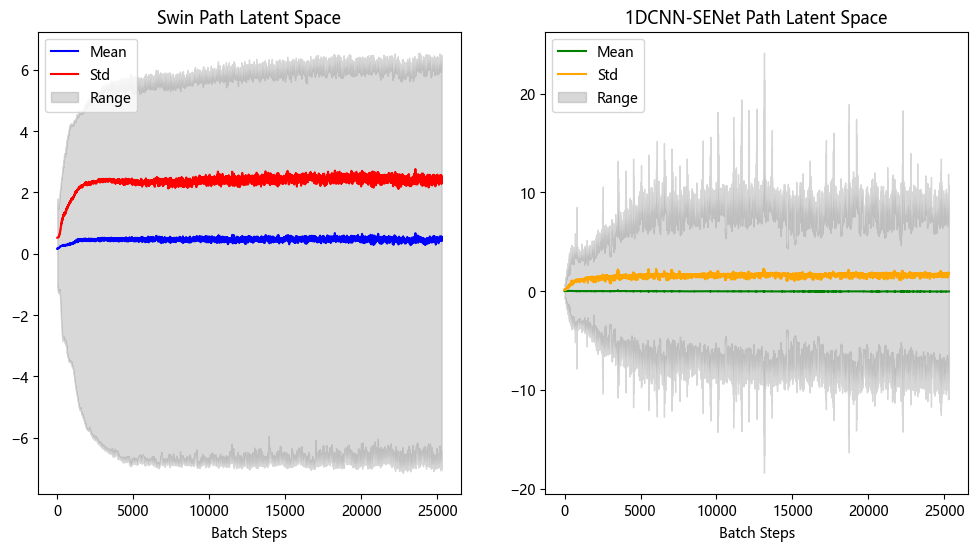

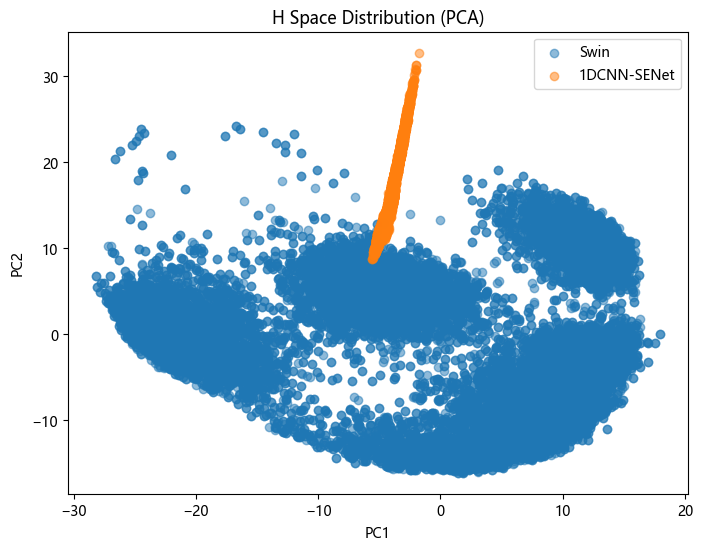

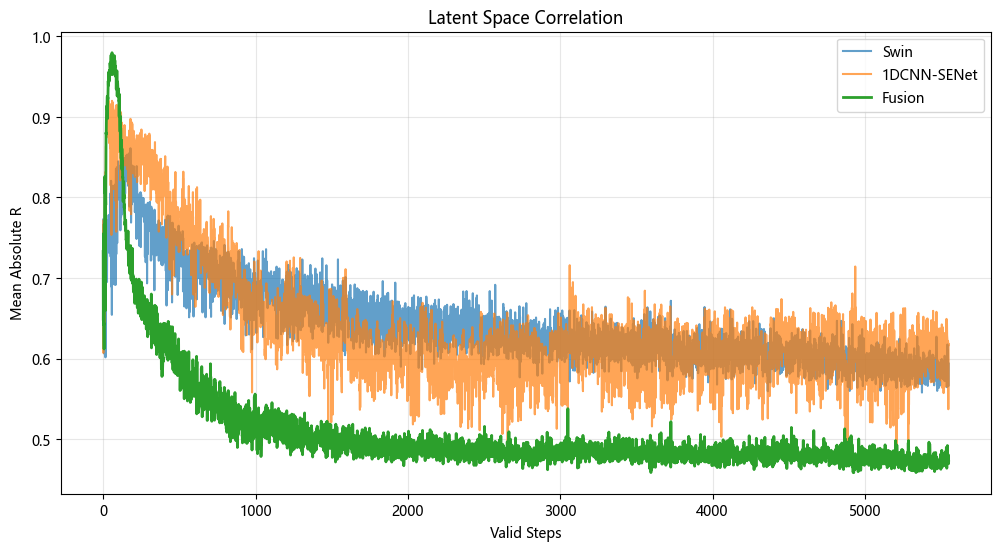


Duration: 397 seconds


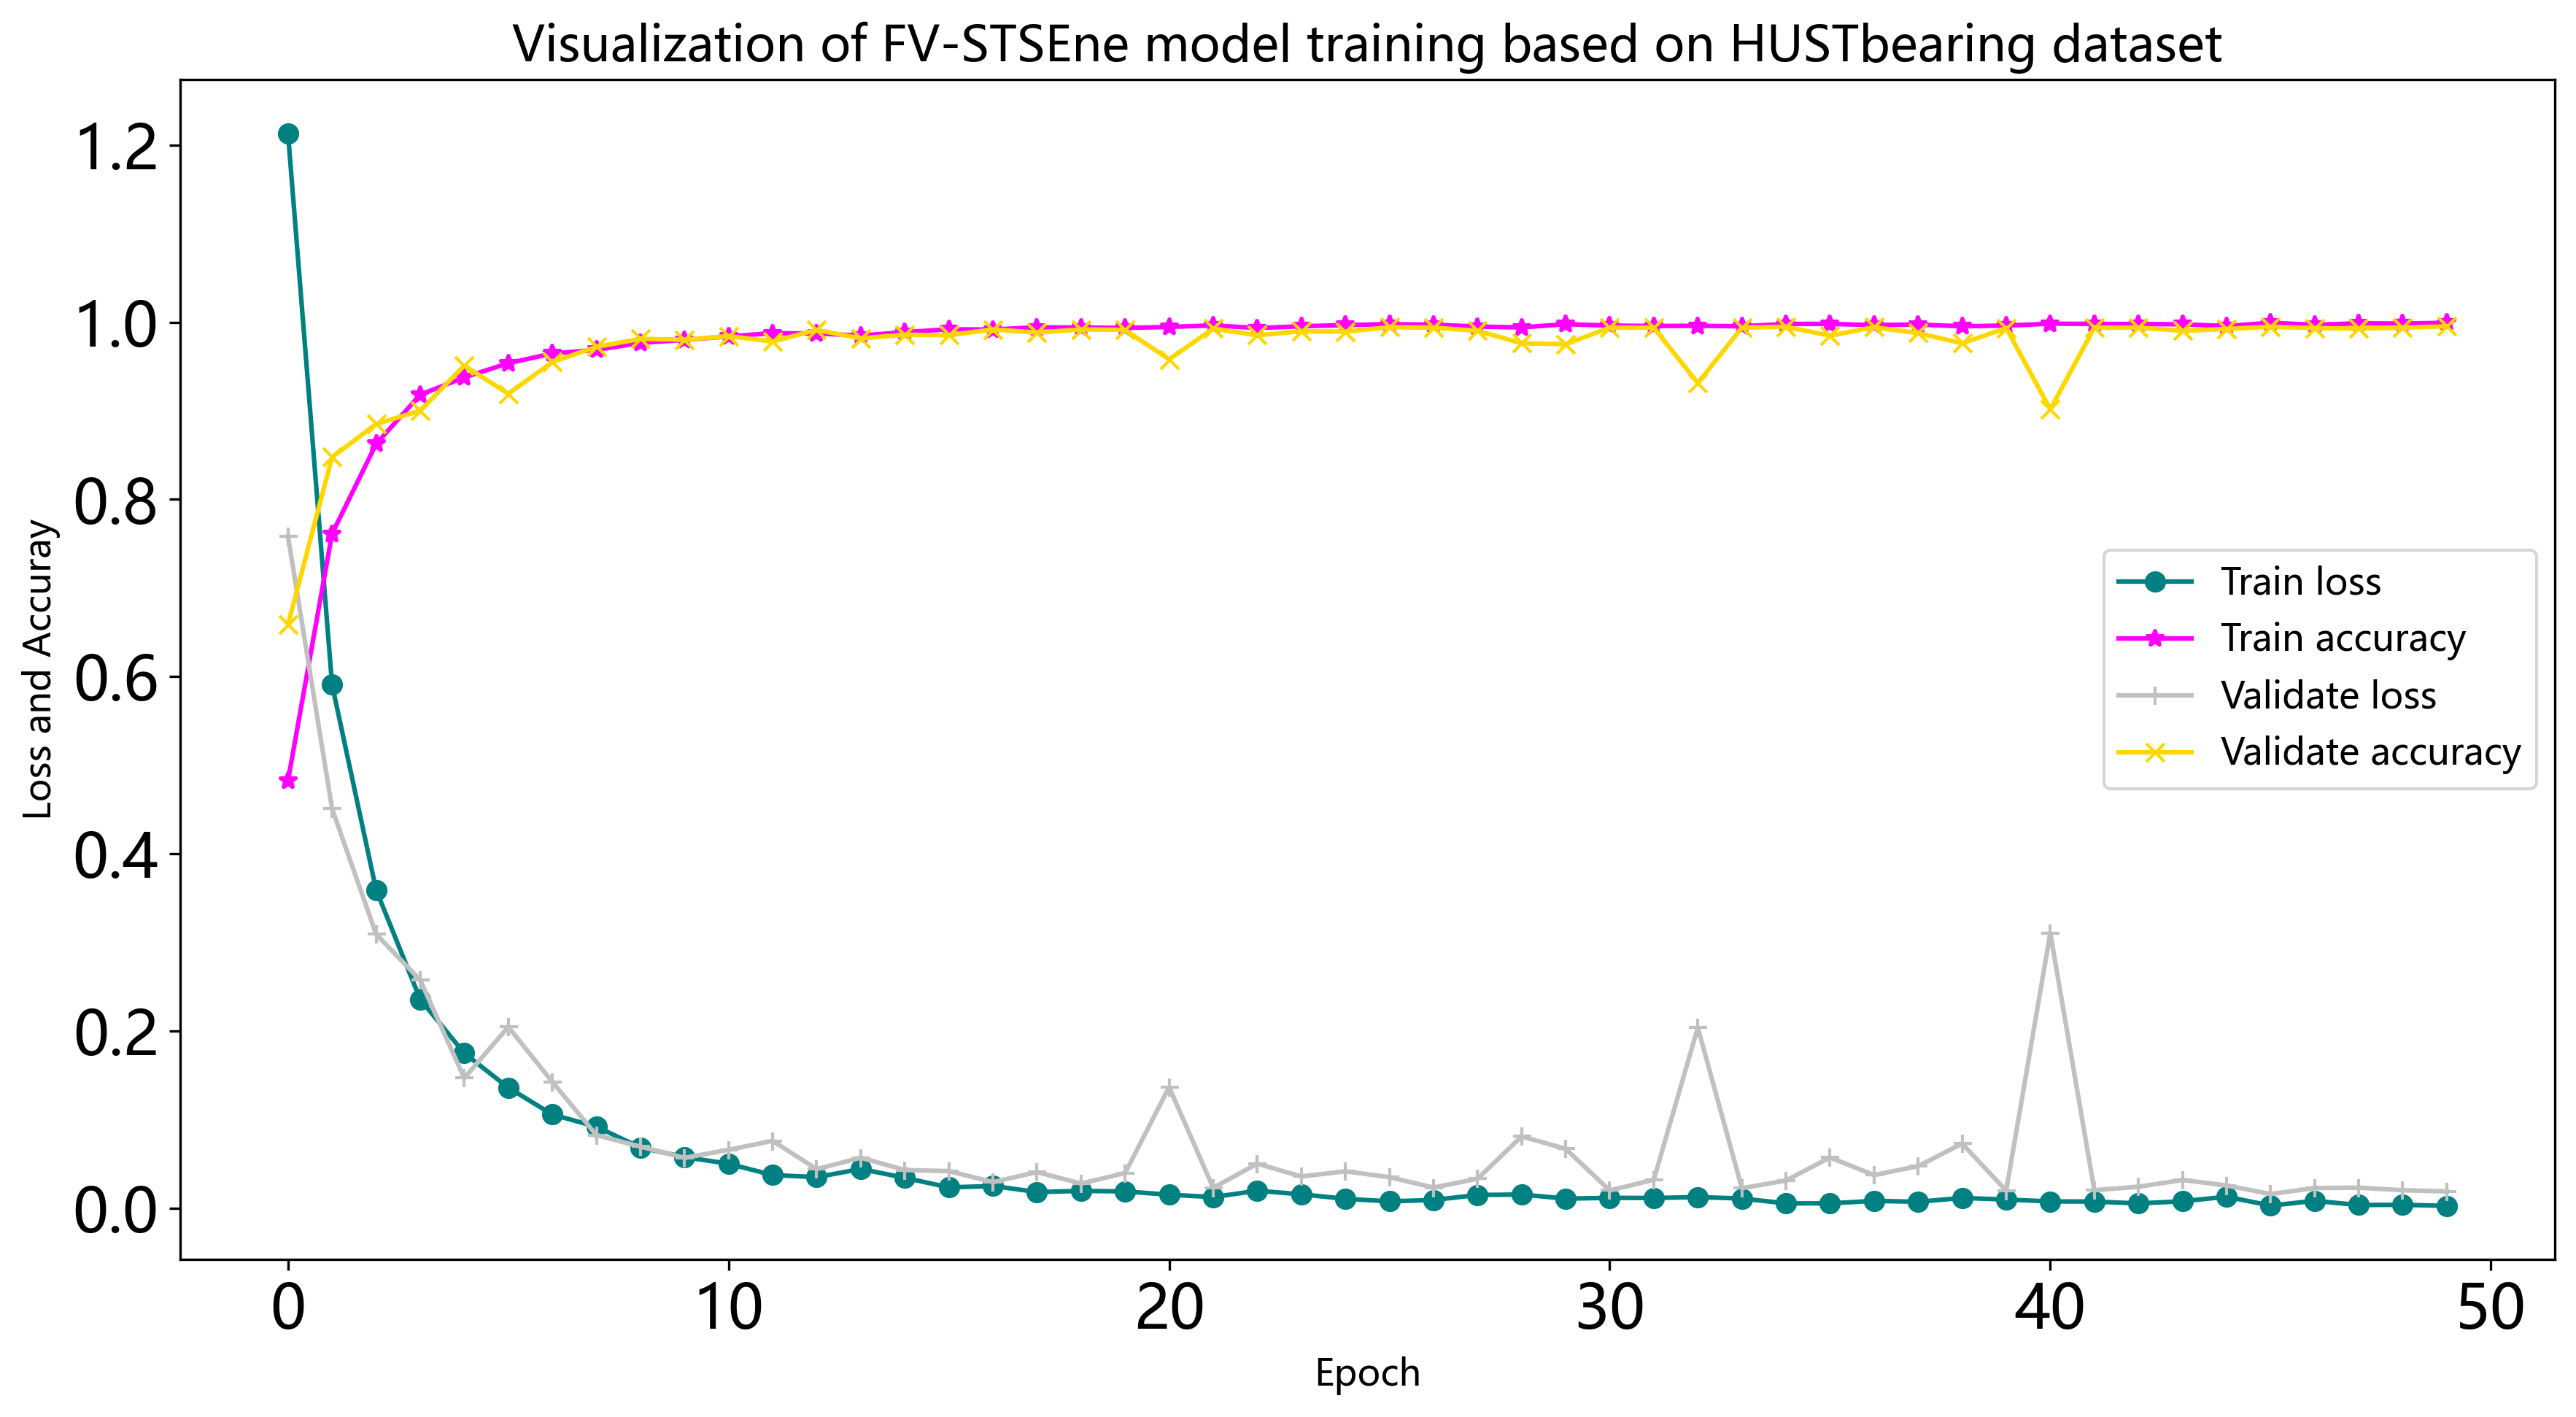

best_accuracy : 0.9954637096774194


In [23]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, train_loader, val_loader, model, optimizer, loss_function):

    # 初始化监控器
    monitor = LatentSpaceMonitor()
    monitor.register_hooks(model)
    model.fusion_module.collect_samples(True)  # 启用采样
    
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model
    
    # 启动特征采集
    model.fusion_module.collect_samples(True)

    
    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()

        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])

            with torch.no_grad():
                swin_feat, cnn_feat, fusion_feat = model.get_features(seq)
                monitor.update_r_values(swin_feat, cnn_feat, fusion_feat)
                
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            
            model.fusion_module.swin_features.clear()
            model.fusion_module.cnn_features.clear()
            model.fusion_module.fusion_features.clear()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
            
            # 清空特征缓存

        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            loss_validate = 0.
            correct_validate = 0
            # 将模型设置为评估模式
            model.eval()
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()

                # 每步打印统计信息
                #if epoch % 25 == 0:
                 #   print(f"Epoch {epoch}-Batch {epoch}:")
                    #print(f"Swin H mean: {np.mean(monitor.h_s_data['mean'][-100:]):.4f}")
                    #print(f"CNN H std: {np.mean(monitor.h_c_data['std'][-100:]):.4f}")
                
                
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数

                
    # 训练结束后添加可视化
    monitor.visualize_statistics(save_path='latent_trend.png')
    #monitor.visualize_distribution(num_samples=500, save_path='latent_dist.png')
    monitor.visualize_distribution(model, num_samples=500, save_path='latent_dist.png')
    monitor.visualize_r_trend(save_path='r_trend.png')
    
    # 释放钩子并保存结果
    monitor.release_hooks()
    model.fusion_module.collect_samples(False)

    # 保存模型前再次确认
    if hasattr(model, 'fusion_module'):
        model.fusion_module._forward_hooks.clear()
        
    # 保存最后的参数
    # torch.save(model, 'final_model_swincnnse.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_swincnnse2.pt')
   
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
  
    # 可视化
    # 创建训练损失、准确率图
    plt.figure(figsize=(14, 7), dpi=300)  # dpi 越大  图片分辨率越高，写论文的话 一般建议300以上设置
    plt.plot(range(epochs), train_loss, color = 'teal', marker='o',label = 'Train loss')
    plt.plot(range(epochs), train_acc, color = 'magenta', marker='*',label = 'Train accuracy')
    plt.plot(range(epochs), validate_loss, color = 'silver', marker='+',label = 'Validate loss')
    plt.plot(range(epochs), validate_acc, color = 'gold', marker='x',label = 'Validate accuracy')

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss and Accuray', fontsize=12)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=12)
    plt.title('Visualization of FV-STSEne model training based on HUSTbearing dataset', fontsize=16)
    plt.savefig("loss-acc.png")
    plt.show()   #显示 lable 
    # 保存结果 方便 后续画图处理（如果有需要的话）
    dump(train_loss, 'train loss') 
    dump(train_acc, 'train acc') 
    dump(validate_loss, 'validate loss') 
    dump(validate_acc, 'validate acc') 
    
    print("best_accuracy :", best_accuracy)



batch_size = 64
epochs = 50
# 模型训练
model_train(batch_size, epochs, train_loader, val_loader, model, optimizer, loss_function)

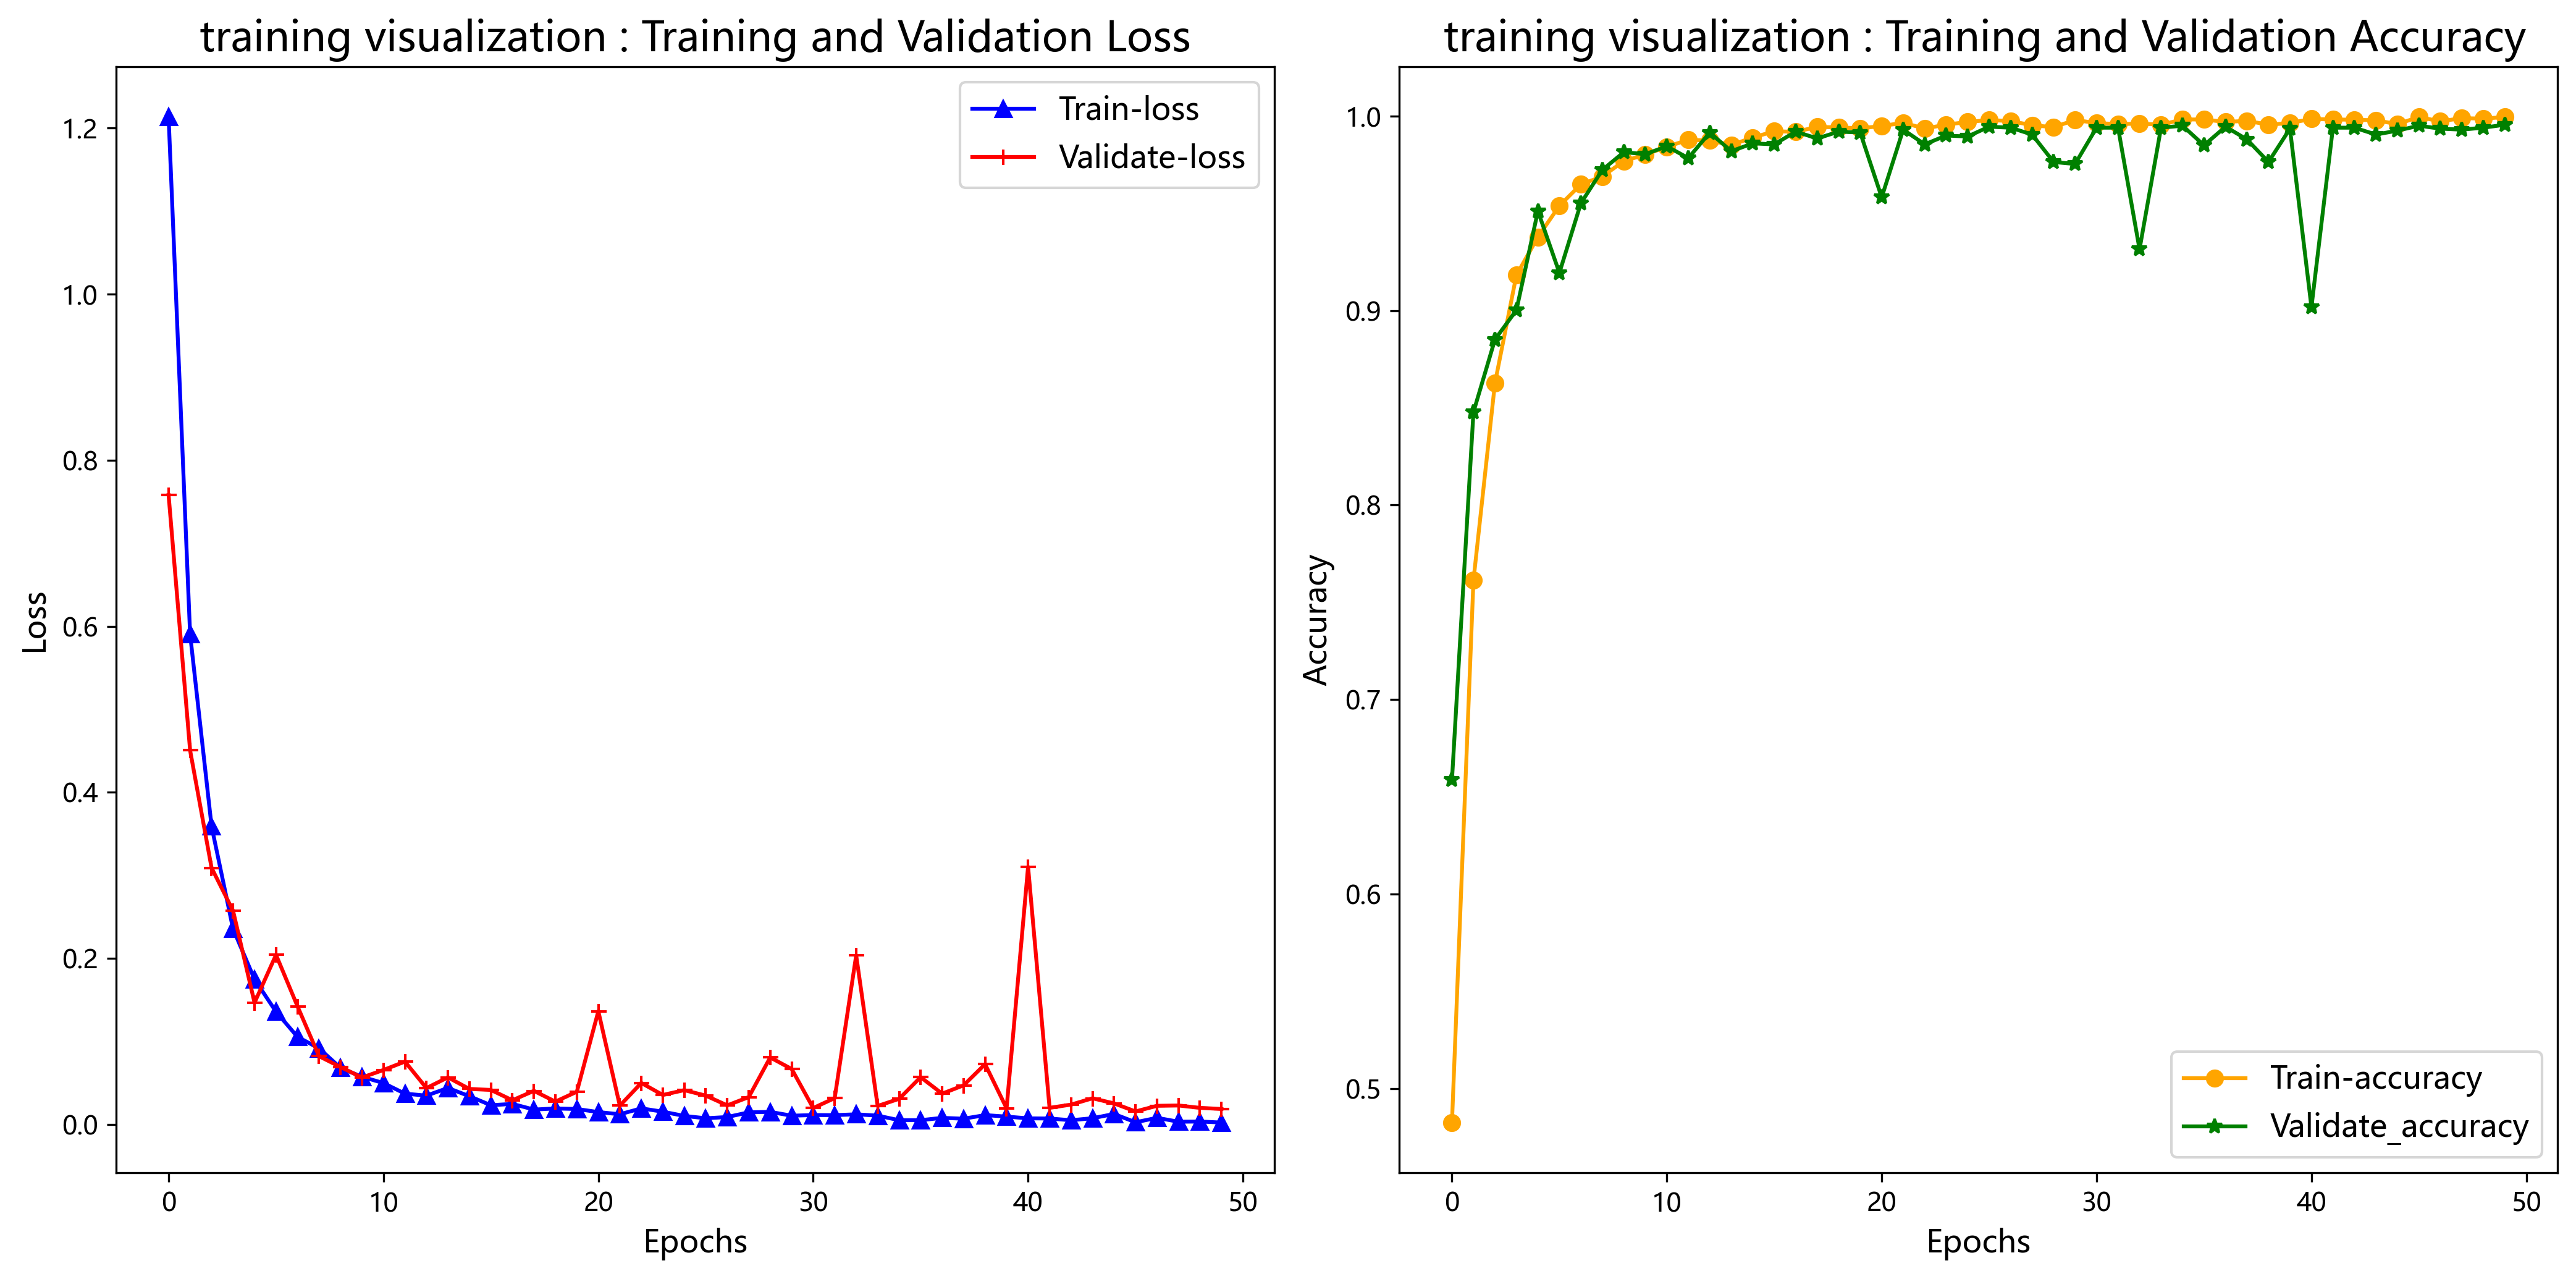

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
matplotlib.rc("font", family='Microsoft YaHei')

# 加载数据

train_loss = load('train loss')
train_acc = load('train acc')

validate_loss = load('validate loss')
validate_acc = load('validate acc')

# 创建训练损失图
# 创建左侧图：损失
plt.figure(figsize=(14, 7), dpi=300)

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train-loss', marker='^', color='blue') # o ^ * s + x   , marker='o'
plt.plot(validate_loss, label='Validate-loss', marker='+', color='red')   # 颜色 曲线类型 可灵活替换
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.title('training visualization : Training and Validation Loss', fontsize=16)

# 创建右侧图：准确率
plt.subplot(1, 2, 2)
plt.plot(train_acc,color = 'orange', marker='o',label = 'Train-accuracy')
plt.plot(validate_acc, color = 'green', marker='*',label = 'Validate_accuracy')


plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.title(' training visualization : Training and Validation Accuracy', fontsize=16)


plt.tight_layout()  # 用于确保子图之间的距离适当
plt.show()

In [25]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import torch
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
model = torch.load('best_model_swincnnse2.pt')
                    #best_model_swincnnse.pt
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
# 使用测试集数据进行推断并计算每一类的分类准确率
true_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

# 提取特征
test_original_labels = []  # 原始测试集 标签
test_model_features = []  # 测试集经过训练后的模型得到的 特征

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_original_labels += test_label.tolist()   # 提取标签

        test_data = test_data.to(device)
        test_output = model(test_data)

        test_model_features += test_output.tolist()  # 提取特征

        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        true_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(true_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_38424\943889099.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_swincnnse2.pt')


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       173
           1     1.0000    1.0000    1.0000       184
           2     0.9952    1.0000    0.9976       207
           3     0.9951    0.9951    0.9951       203
           4     1.0000    0.9948    0.9974       193

    accuracy                         0.9979       960
   macro avg     0.9981    0.9980    0.9980       960
weighted avg     0.9979    0.9979    0.9979       960



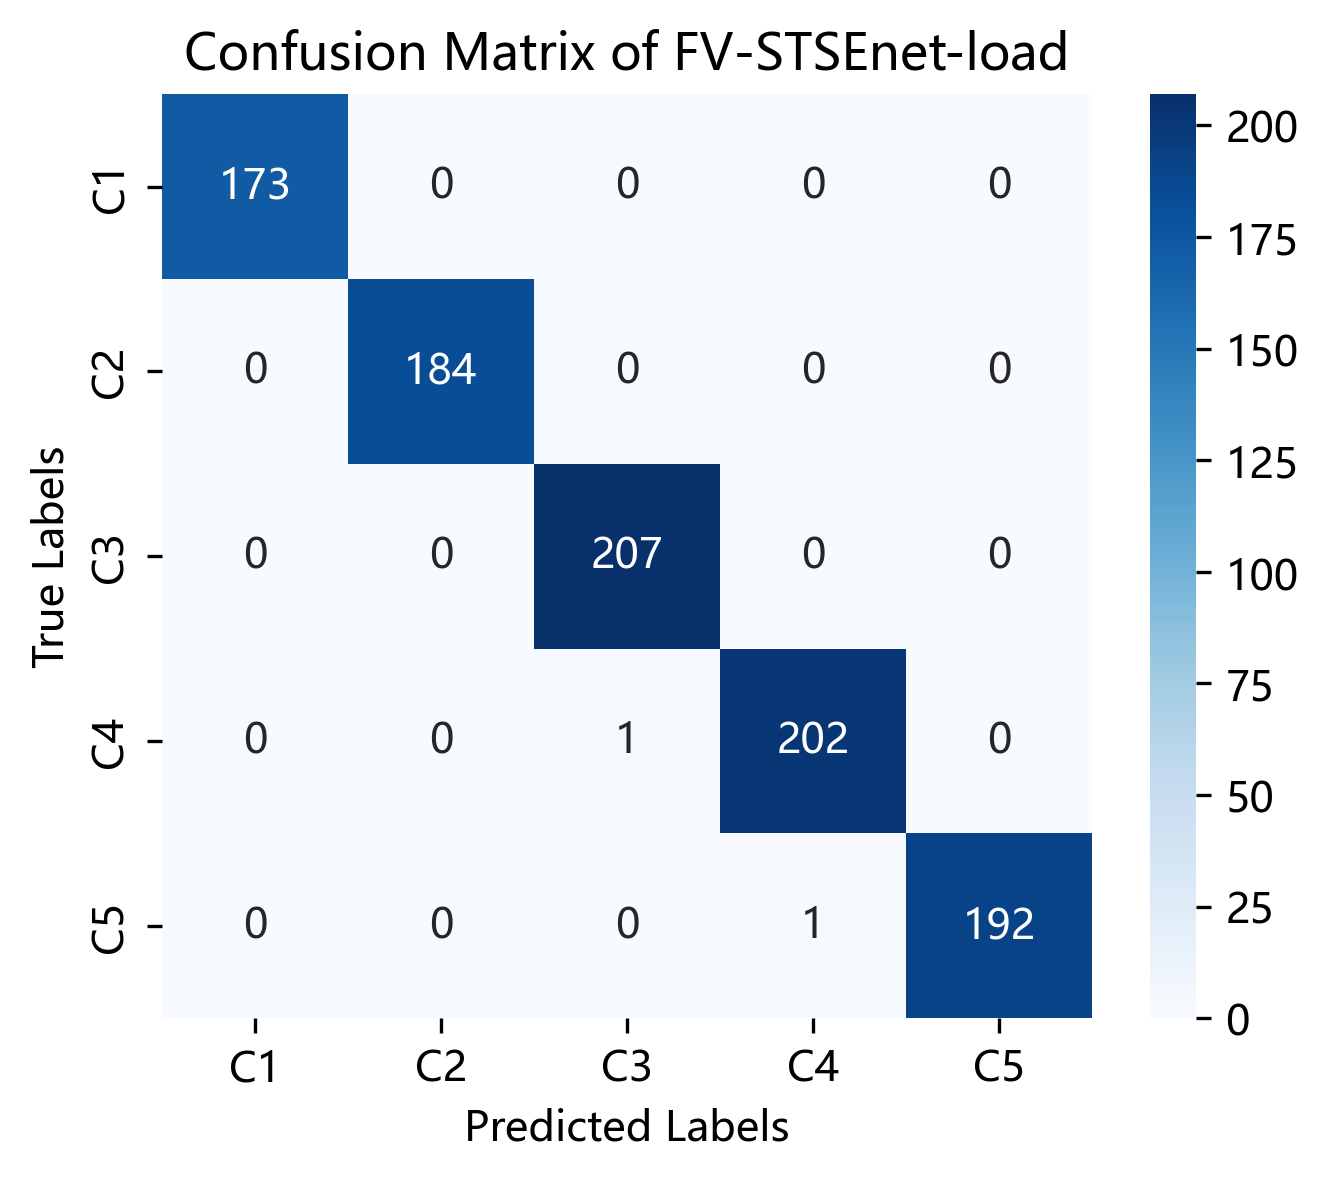

In [26]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
}

# 绘制混淆矩阵的颜色取值
#https://blog.csdn.net/m0_68795816/article/details/125686360

plt.figure(figsize=(5, 4), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of FV-STSEnet-load')
plt.savefig("FV-SASEnet.png")
plt.show()

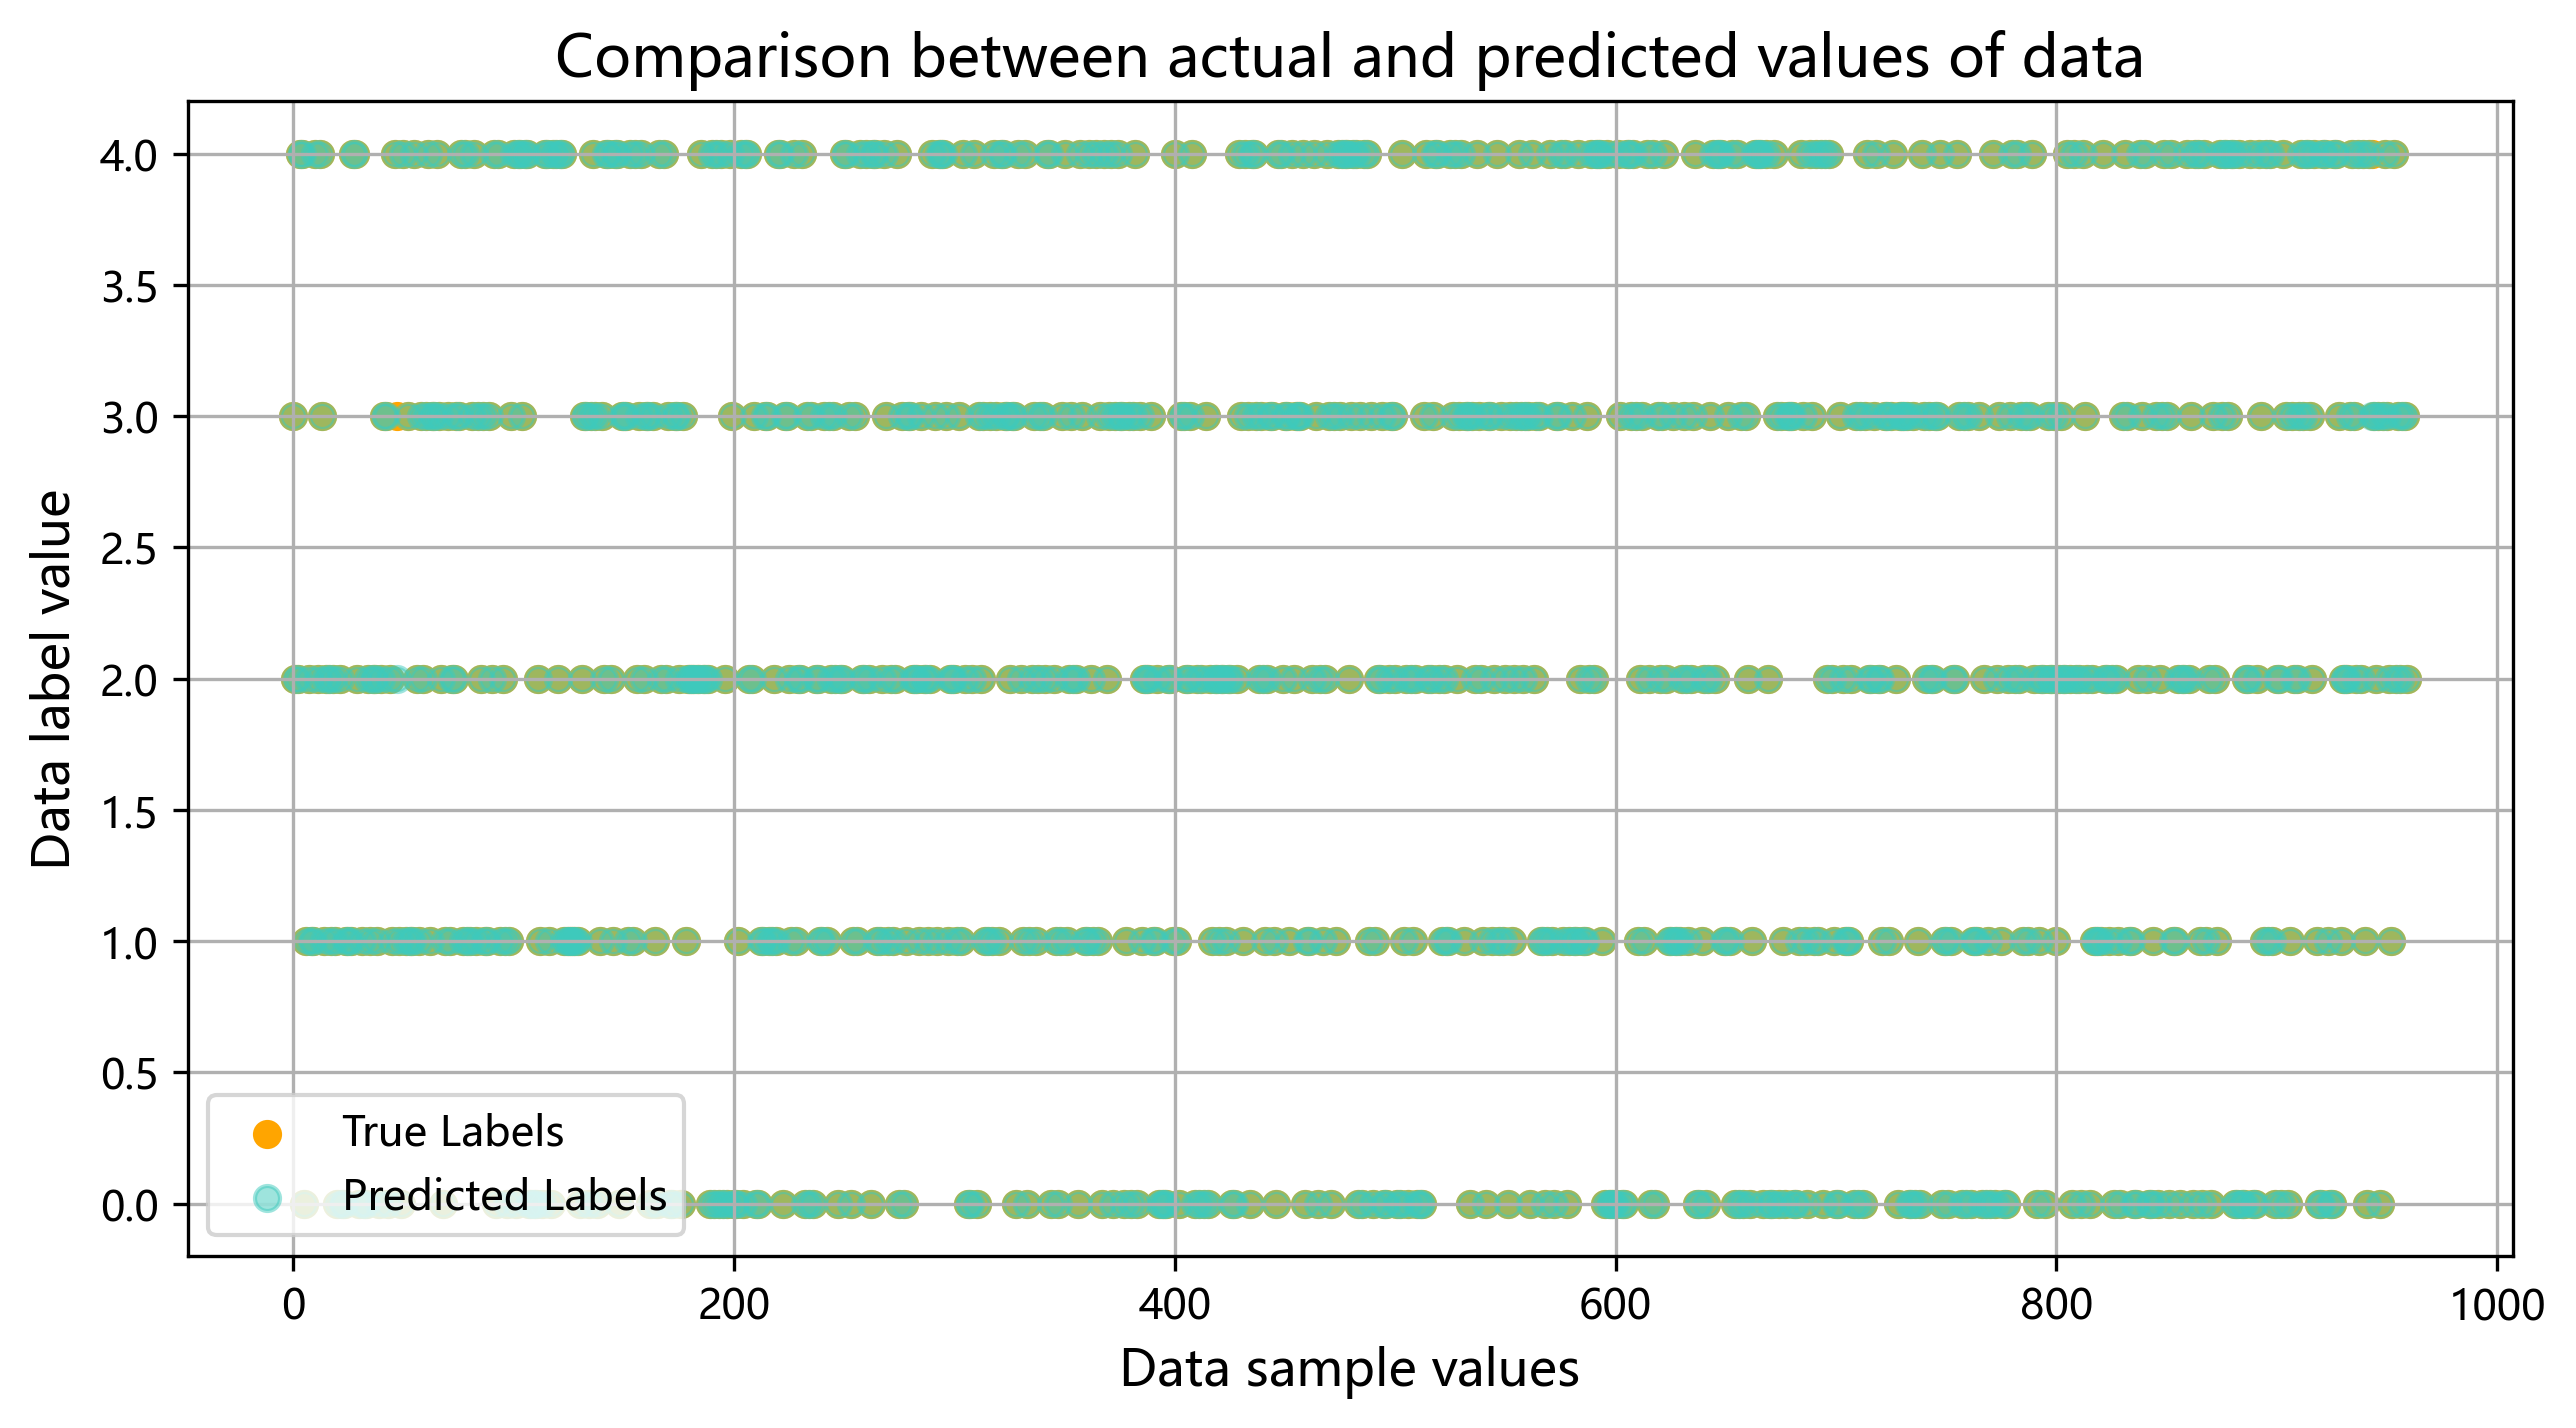

In [27]:
import matplotlib.pyplot as plt

# 类别标签
x = [i for i in range(len(true_labels))]

# 可视化结果
plt.figure(figsize=(10, 5), dpi=300)

# 绘制真实标签的折线图
plt.scatter(x, true_labels,color='orange', label='True Labels', alpha=1)
# 绘制预测标签的折线图
plt.scatter(x, predicted_labels , color='#3ECABD', label='Predicted Labels', alpha=0.5)

# plt.plot(x, class_labels,color='red', label='True Labels', alpha=0.5)
# # 绘制预测标签的折线图
# plt.plot(x, predicted_labels , color='green', label='Predicted Labels')

plt.title('Comparison between actual and predicted values of data', fontsize=14)
plt.xlabel('Data sample values', fontsize=12)
plt.ylabel('Data label value', fontsize=12)
# plt.xticks(class_labels)
plt.legend()
plt.grid(True)
plt.savefig("ture and predicted.png")
plt.show()

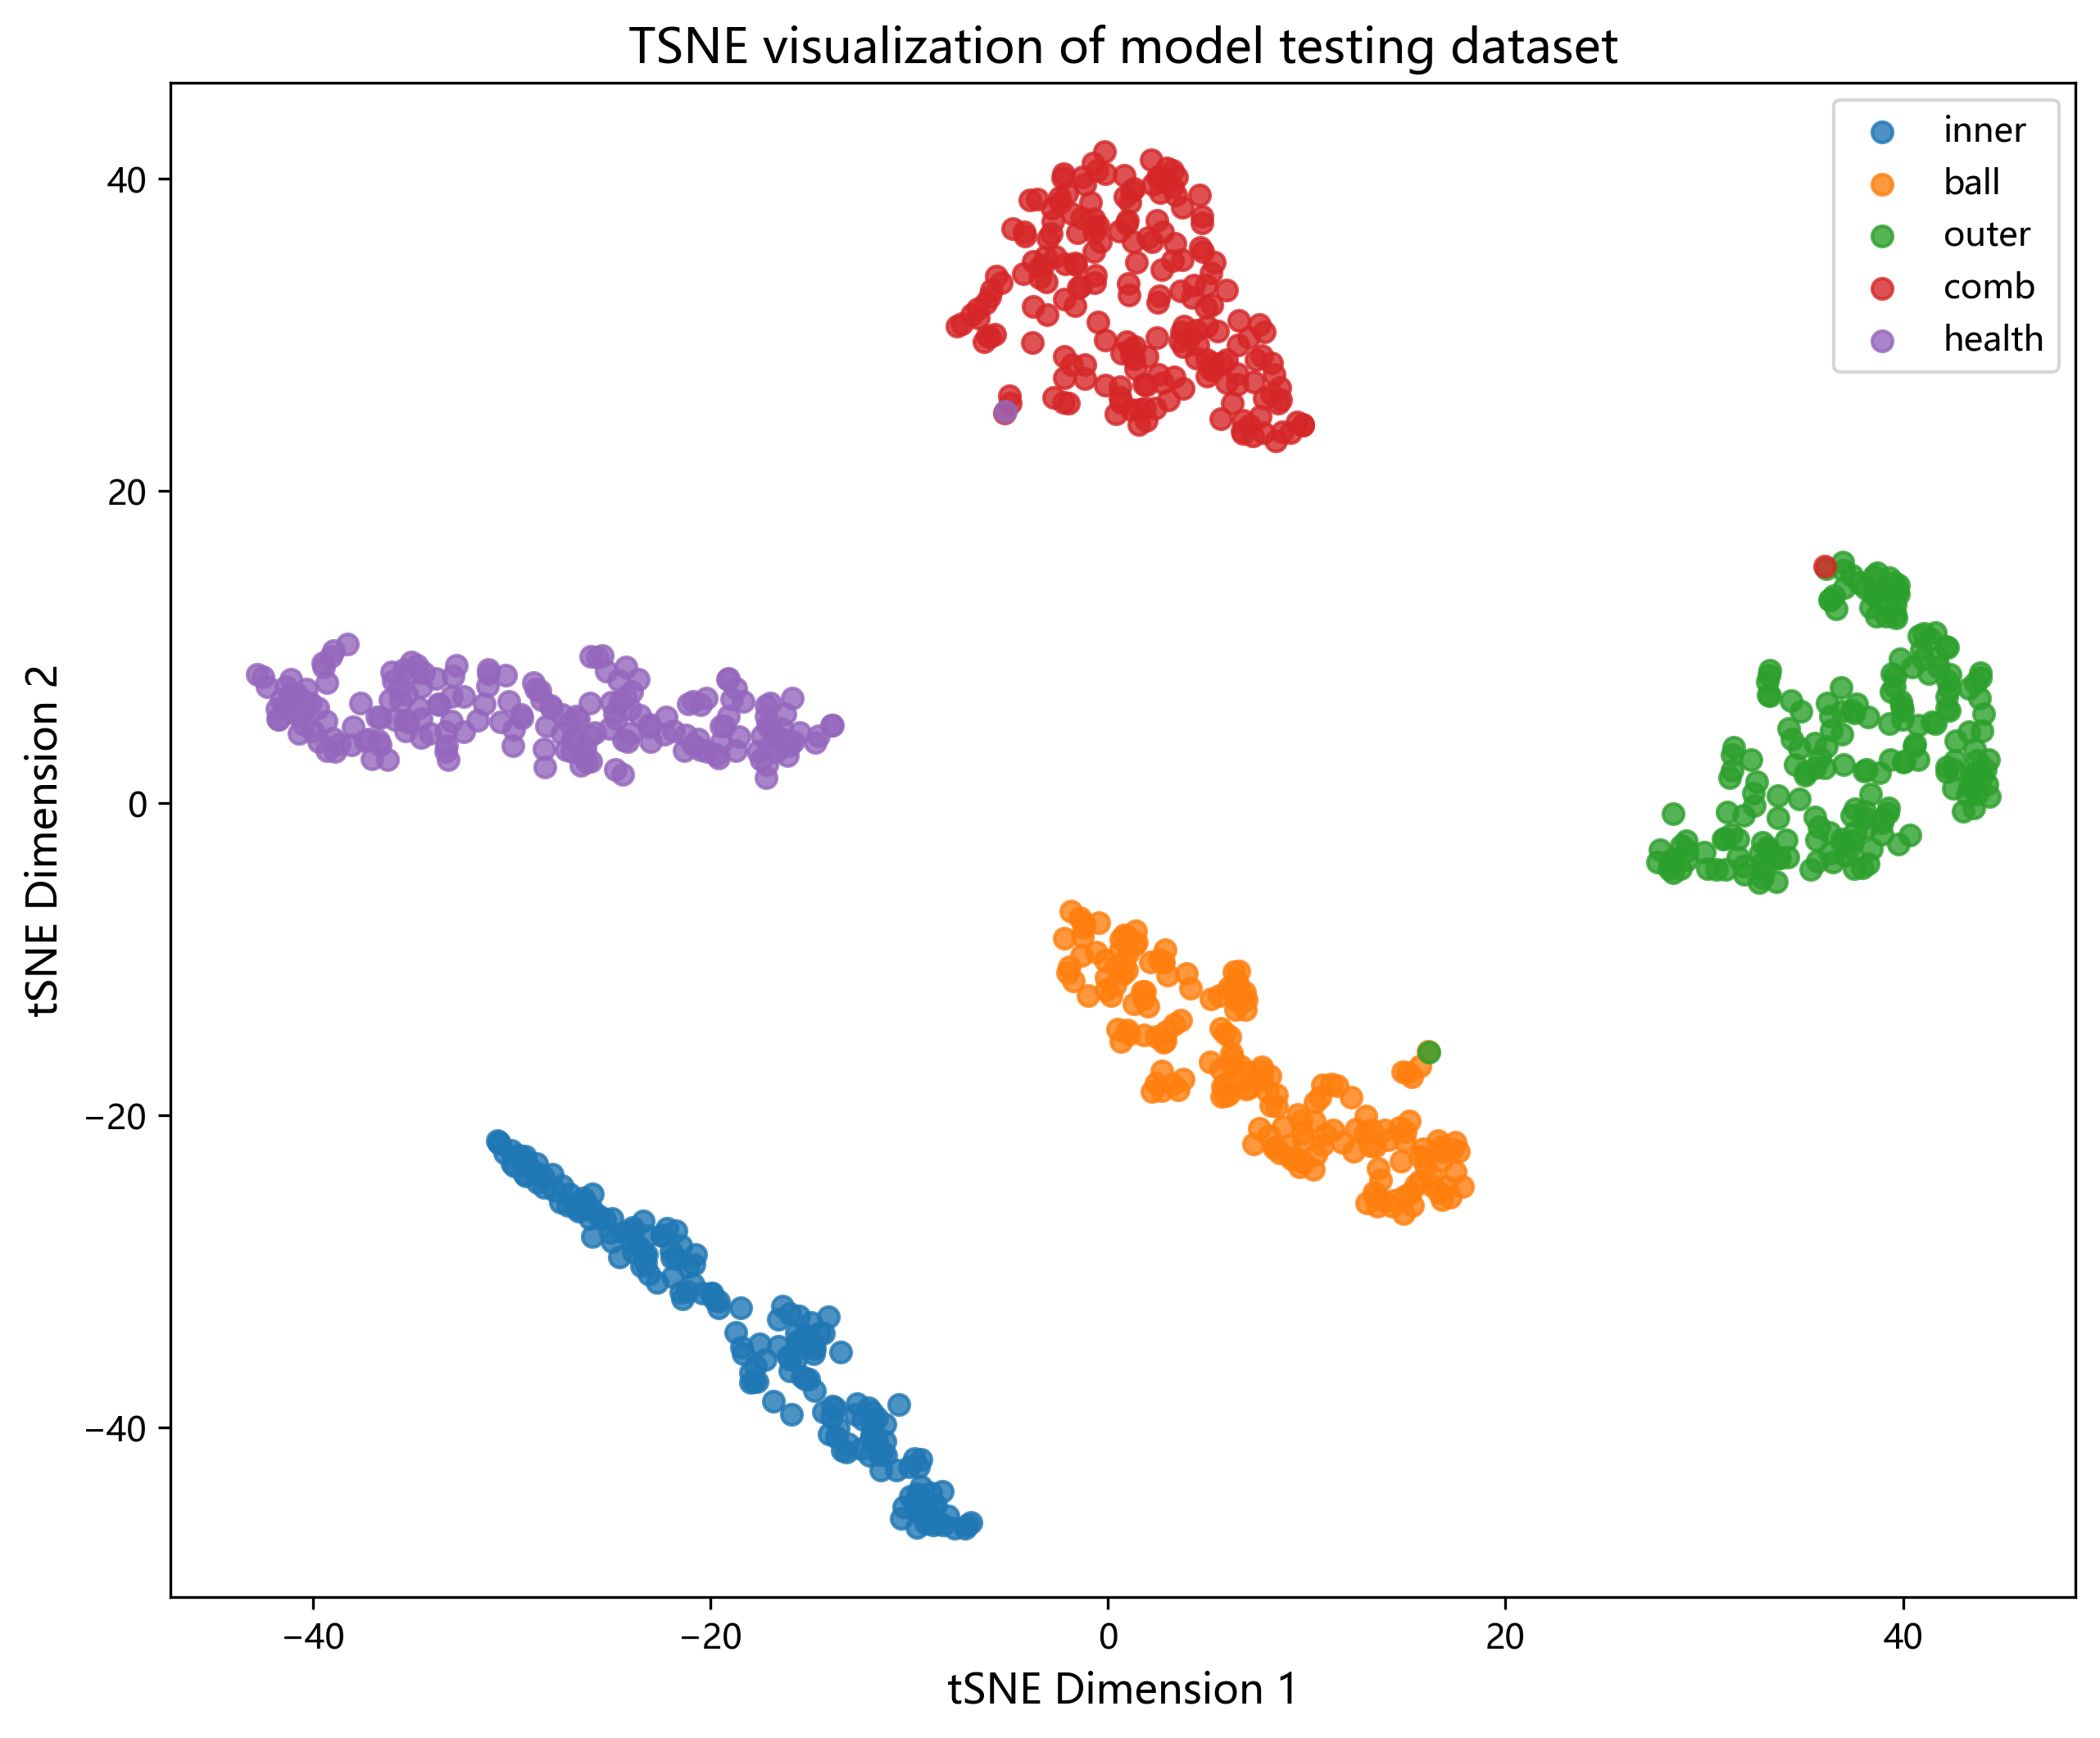

In [28]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')
from sklearn.manifold import TSNE

# 训练好的模型 测试集 进行 t-SNE 降维
def plot_model_TSNE(test_model_features, test_original_labels, num_classes, class_labels_name):
    features = np.array(test_model_features)
    labels = np.array(test_original_labels)

    # 初始化 t-SNE 模型
    tsne = TSNE(n_components=2, random_state=42)

    # 对原始数据进行 t-SNE 降维
    features_tsne = tsne.fit_transform(features)

    # 可视化结果
    plt.figure(figsize=(10, 8), dpi=300)
    # 绘制每个类别的散点图，并指定label
    for i in range(num_classes):
        plt.scatter(features_tsne[labels == i, 0], features_tsne[labels == i, 1], label=class_labels_name[i], alpha=0.8)
    plt.title('TSNE visualization of model testing dataset', fontsize=14)
    plt.xlabel('tSNE Dimension 1', fontsize=12)
    plt.ylabel('tSNE Dimension 2', fontsize=12)
    # 显示legend
    plt.legend()
    # plt.show()
    plt.savefig('FV-STSEnet test TSNE', dpi=300)


num_classes = 5  # 5分类
# 类别标签
class_labels_name = ['inner','ball','outer','comb','health']

# 训练好的模型 测试集 进行 t-SNE 降维
plot_model_TSNE(test_model_features, test_original_labels, num_classes, class_labels_name)

In [29]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')
from sklearn.manifold import TSNE

# 测试集   注意 这里加载 最原始 的数据集， 不加载预处理后的数据
test_x = load('test_xdata')
test_y = load('test_ylabel')

# 加载数据
testloader = Data.DataLoader(dataset=Data.TensorDataset(test_x, test_y),
                                batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_original_features = []  # 原始测试集 特征

for test_data, test_label in testloader:
    test_original_features += test_data.tolist()# 提取特征


    
num_classes = 5  # 5分类
# 类别标签
class_labels_name = ['inner','ball','outer','comb','health']

# 原始 测试集 进行 t-SNE 降维
def plot_orignal_TSNE(test_original_features, test_original_labels, num_classes, class_labels_name):
    features = np.array(test_original_features)
    labels = np.array(test_original_labels)

    # 初始化 t-SNE 模型
    tsne = TSNE(n_components=2, random_state=42)

    # 对原始数据进行 t-SNE 降维
    features_tsne = tsne.fit_transform(features)

    # 可视化结果
    plt.figure(figsize=(10, 8), dpi=300)
    # 绘制每个类别的散点图，并指定label
    for i in range(num_classes):
        plt.scatter(features_tsne[labels == i, 0], features_tsne[labels == i, 1], label=class_labels_name[i], alpha=0.8)
    plt.title('TSNE visualization of raw test dataset', fontsize=14)
    plt.xlabel('tSNE Dimension 1', fontsize=12)
    plt.ylabel('tSNE Dimension 2', fontsize=12)
    # 显示legend
    plt.legend()
    # plt.show()
    plt.savefig('Raw test TSNE', dpi=300)


# 原始 测试集 进行 t-SNE 降维
plot_orignal_TSNE(test_original_features, test_original_labels, num_classes, class_labels_name)

FileNotFoundError: [Errno 2] No such file or directory: 'test_xdata'